# RNN Language Model

In [1]:
pip install datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b3d66dc6da148b6f701913a4dab01041b115153124eeebed2bcfd3735350841b
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resol

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from datasets import load_dataset
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report
import numpy as np
from tqdm.auto import tqdm

from timeit import default_timer as timer

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
dataset = load_dataset("eriktks/conll2003", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [5]:
print("Dataset loaded:")
print(dataset)

Dataset loaded:
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [6]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [7]:
print(dataset['train'][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [8]:
dataset['train'].features['ner_tags'].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

## Get tag list from dataset features

In [9]:
tag_names = dataset['train'].features['ner_tags'].feature.names
tag_to_ix = {tag: i for i, tag in enumerate(tag_names)}
PAD_TAG = "<PAD>"
if PAD_TAG not in tag_to_ix:
     tag_to_ix[PAD_TAG] = len(tag_names) #
ix_to_tag = {v: k for k, v in tag_to_ix.items()}
tag_pad_idx = tag_to_ix[PAD_TAG]
print(f"Tag vocabulary size: {len(tag_to_ix)}")
print(f"Tag map: {tag_to_ix}")
print(f"Padding tag index: {tag_pad_idx}")

Tag vocabulary size: 10
Tag map: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8, '<PAD>': 9}
Padding tag index: 9


In [10]:
word_to_ix = {}
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word_to_ix[PAD_TOKEN] = 0
word_to_ix[UNK_TOKEN] = 1
word_idx_counter = 2

In [11]:
for example in dataset['train']:
    for word in example['tokens']:
        if word not in word_to_ix:
            word_to_ix[word] = word_idx_counter
            word_idx_counter += 1
print(f"Word vocabulary size: {len(word_to_ix)}")


Word vocabulary size: 23625


In [12]:
char_to_ix = {}
PAD_CHAR =  "|"
UNK_CHAR = "^"
char_to_ix[PAD_CHAR] = 0
char_to_ix[UNK_CHAR] = 1
char_idx_counter = 2

In [13]:
for example in dataset['train']:
    for word in example['tokens']:
        for char in word:
            if char not in char_to_ix:
                char_to_ix[char] = char_idx_counter
                char_idx_counter += 1
print(f"Character vocabulary size: {len(char_to_ix)}")
print("-" * 30)

Character vocabulary size: 86
------------------------------


In [14]:
class CoNLLDataset(Dataset):
    def __init__(self, data_split, word_to_ix, char_to_ix, tag_to_ix):
        self.data = data_split
        self.word_to_ix = word_to_ix
        self.char_to_ix = char_to_ix
        self.tag_to_ix = tag_to_ix # Keep for reference, though tags are indices
        self.unk_word_ix = word_to_ix[UNK_TOKEN]
        self.unk_char_ix = char_to_ix[UNK_CHAR]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        sentence_tokens = example['tokens']
        # Tags are already numerical indices from the dataset
        tag_indices = example['ner_tags']

        # Word indices
        word_indices = [self.word_to_ix.get(w, self.unk_word_ix) for w in sentence_tokens]

        # Character indices per word
        chars_in_sentence = []
        for word in sentence_tokens:
            char_indices = [self.char_to_ix.get(c, self.unk_char_ix) for c in word]
            chars_in_sentence.append(torch.tensor(char_indices, dtype=torch.long))

        return (torch.tensor(word_indices, dtype=torch.long),
                chars_in_sentence, # List of tensors (char indices per word)
                torch.tensor(tag_indices, dtype=torch.long))

In [ ]:
# the dog was angry
# 0    1   0    0
# Hew was angry
# 0    0    0

# ->
# the dog was angry
# the__ dog__ was__ angry
# 0    1   0    0

# He was angry <pad>
# He___ was__ angry <pad>
# 0    0    0    -1

In [23]:
def collate_fn_char_conll(batch):
    """ Handles padding using global PAD indices """
    word_pad_idx = word_to_ix[PAD_TOKEN]
    char_pad_idx = char_to_ix[PAD_CHAR]
    tag_pad_idx_local = tag_pad_idx # Use the globally defined tag padding index

    word_indices_list, chars_in_sentence_list, tag_indices_list = zip(*batch)

    # Pad word sequences and get word lengths
    word_lengths = torch.tensor([len(seq) for seq in word_indices_list], dtype=torch.long)
    padded_word_indices = pad_sequence(word_indices_list, batch_first=True, padding_value=word_pad_idx)

    # Pad tag sequences
    padded_tag_indices = pad_sequence(tag_indices_list, batch_first=True, padding_value=tag_pad_idx_local)

    # padded_word_indices.shape: [batch_size, max_seq_len]
    # Pad character sequences
    max_sent_len = padded_word_indices.size(1)
    max_word_len = 0
    for sent_chars in chars_in_sentence_list:
        for word_chars in sent_chars:
             if len(word_chars) > max_word_len:
                 max_word_len = len(word_chars)

    if max_word_len == 0:
        max_word_len = 1

    padded_chars_batch = []

    for i, sent_chars in enumerate(chars_in_sentence_list):
        padded_sent_chars = []
        num_words_in_sent = word_lengths[i].item()

        for j in range(max_sent_len):
            if j < num_words_in_sent:
                word_chars = sent_chars[j] if j < len(sent_chars) else torch.tensor([], dtype=torch.long) # Handle if sentence was shorter than max_len
                char_len = len(word_chars)
                padding_needed = max_word_len - char_len
                padded_word_chars = F.pad(word_chars, (0, padding_needed), value=char_pad_idx)
                padded_sent_chars.append(padded_word_chars)
            else: # Padded word position
                dummy_word_chars = torch.full((max_word_len,), fill_value=char_pad_idx, dtype=torch.long)
                padded_sent_chars.append(dummy_word_chars)

        padded_chars_batch.append(torch.stack(padded_sent_chars))

    final_padded_chars = torch.stack(padded_chars_batch)

    return (padded_word_indices, final_padded_chars, padded_tag_indices,
            word_lengths)

In [16]:
class CharCNN_LSTM_NER(nn.Module):
    def __init__(self,
                 word_vocab_size,
                 tagset_size,
                 char_vocab_size,
                 word_embedding_dim,
                 char_embedding_dim,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 lstm_hidden_dim,
                 word_pad_idx,
                 char_pad_idx,
                 lstm_layers=2,
                 dropout_prob=0.5,
                 use_bilstm=True):
        super(CharCNN_LSTM_NER, self).__init__()

        self.word_embedding_dim = word_embedding_dim
        self.char_embedding_dim = char_embedding_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.char_cnn_filter_num = char_cnn_filter_num
        self.char_cnn_kernel_size = char_cnn_kernel_size
        self.use_bilstm = use_bilstm

        self.word_embeddings = nn.Embedding(word_vocab_size, word_embedding_dim, padding_idx=word_pad_idx)
        self.char_embeddings = nn.Embedding(char_vocab_size, char_embedding_dim, padding_idx=char_pad_idx)

        self.char_cnn = nn.Conv1d(in_channels=char_embedding_dim,
                                  out_channels=char_cnn_filter_num,
                                  kernel_size=char_cnn_kernel_size,
                                  padding="same")

        lstm_input_dim = word_embedding_dim + char_cnn_filter_num
        self.lstm = nn.LSTM(lstm_input_dim,
                            lstm_hidden_dim,
                            batch_first=True,
                            bidirectional=self.use_bilstm,
                            dropout=dropout_prob)

        # Adjust linear layer input size if BiLSTM is used
        linear_input_dim = lstm_hidden_dim * 2 if self.use_bilstm else lstm_hidden_dim
        self.hidden2tag = nn.Linear(linear_input_dim, tagset_size)

    def forward(self, word_indices, char_indices, word_lengths):
        # word_indices: (batch_size, max_sent_len)
        # char_indices: (batch_size, max_sent_len, max_word_len)
        # word_lengths: (batch_size,) - original lengths of sentences

        batch_size = word_indices.size(0)
        max_sent_len = word_indices.size(1)
        max_word_len = char_indices.size(2)

        # 1. Word Embeddings
        word_embs = self.word_embeddings(word_indices)

        # 2. Character Embeddings and CNN
        char_embs = self.char_embeddings(char_indices)

        # Reshape for CNN
        # char_embs_reshaped.shape: [batch_size, max_sent_len, max_word_len, char_embedding_dim]
        char_embs_reshaped = char_embs.view(batch_size * max_sent_len, max_word_len, self.char_embedding_dim)
        # char_embs_reshaped.shape: [batch_size * max_sent_len, max_word_len, char_embedding_dim]

        char_embs_transposed = char_embs_reshaped.transpose(1, 2)
        # char_embs_reshaped.shape: [batch_size * max_sent_len, char_embedding_dim, max_word_len]

        # CNN + Max Pooling
        char_cnn_out = self.char_cnn(char_embs_transposed)
        # Correct application of max_pool1d over the length dimension
        # Input: (N, C, L), Kernel size should be L to pool over the entire length
        # char_features.shape: [batch_size * max_sent_len, out_chanels, max_word_len]
        char_features = F.max_pool1d(char_cnn_out, kernel_size=char_cnn_out.size(2))
        # char_features.shape: [batch_size * max_sent_len, out_chanels, 1]
        char_features_squeezed = char_features.squeeze(2)
        # char_features_squeezed.shape: [batch_size * max_sent_len, out_chanels]

        # Reshape back
        char_features_final = char_features_squeezed.view(batch_size, max_sent_len, self.char_cnn_filter_num)
        # char_features_squeezed.shape: [batch_size, max_sent_len, out_chanels]

        # 3. Concatenate
        combined_features = torch.cat((word_embs, char_features_final), dim=2)
        # combined_features.shape: [batch_size, max_sent_len, word_embedding_dim + out_chanels]

        # 4. Pack sequence (Handle potential zero lengths)
        # Ensure lengths passed to pack_padded_sequence are on CPU
        lengths_cpu = word_lengths.cpu()
        packed_features = pack_padded_sequence(combined_features, lengths_cpu, batch_first=True, enforce_sorted=False)

        # 5. LSTM
        packed_lstm_out, _ = self.lstm(packed_features)

        # 6. Unpack sequence
        lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True, total_length=max_sent_len)

        # 7. Linear Layer
        tag_space = self.hidden2tag(lstm_out)

        return tag_space

In [17]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss = 0
    steps = 0

    for i, batch in enumerate(data_loader):
        word_indices, char_indices, tag_indices, word_lengths = batch
        word_indices = word_indices.to(device)
        char_indices = char_indices.to(device)
        tag_indices = tag_indices.to(device)

        optimizer.zero_grad()

        tag_scores = model(word_indices, char_indices, word_lengths)
        # this is the fast way to calculate the cross entropy
        # tag_scores.shape: [babtch_size, max_seq_len, out_features]
        scores_flattened = tag_scores.view(-1, model.hidden2tag.out_features)
        # tag_scores.shape: [babtch_size * max_seq_len, out_features]
        # tag_indices.shape: [babtch_size, max_seq_len, 1]
        tags_flattened = tag_indices.view(-1)
        # tag_indices.shape: [babtch_size * max_seq_len]

        loss = loss_fn(scores_flattened, tags_flattened)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        steps += 1

        train_loss += loss.item()

    return train_loss / steps




def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss = 0
    steps = 0
    all_preds = []
    all_trues = []

    with torch.inference_mode():
        for i, batch in enumerate(data_loader):

            word_indices, char_indices, tag_indices, word_lengths = batch
            word_indices = word_indices.to(device)
            char_indices = char_indices.to(device)
            tag_indices = tag_indices.to(device)

            tag_scores = model(word_indices, char_indices, word_lengths) # word_lengths on CPU

            scores_flattened = tag_scores.view(-1, model.hidden2tag.out_features)
            tags_flattened = tag_indices.view(-1)

            loss = loss_fn(scores_flattened, tags_flattened)
            steps += 1

            test_loss += loss.item()

            preds = torch.argmax(tag_scores, dim=2) # (batch_size, seq_len)

            for i in range(preds.size(0)):
                seq_len = word_lengths[i].item()
                pred_seq = preds[i, :seq_len].cpu().numpy()
                label_seq = tag_indices[i, :seq_len].cpu().numpy()
                pred_tags = [ix_to_tag.get(idx, 'O') for idx in pred_seq]
                label_tags = [ix_to_tag.get(idx, 'O') for idx in label_seq]
                all_preds.append(pred_tags)
                all_trues.append(label_tags)



    precision = precision_score(all_trues, all_preds)
    recall = recall_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds)
    report = classification_report(all_trues, all_preds, digits=4)
    all_preds = [pred for sublist in all_preds for pred in sublist]
    all_trues = [true for sublist in all_trues for true in sublist]
    accuracy = sum([pred == true for pred, true in zip(all_preds, all_trues)]) / len(all_preds)

    return test_loss / steps, precision, recall, f1, accuracy, report


def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "test_loss": [],
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, precision, recall, f1, accuracy, report = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_precision: {precision:.4f} | "
            f"test_recall: {recall:.4f} | "
            f"test_f1: {f1:.4f} | "
            f"accuracy: {accuracy:.4f} | "
            f"time: {(end_time-start_time):.4f}\n"
            f"test report: \n{report} | "
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]


    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


# RNN Training

In [24]:
len(char_to_ix), len(word_to_ix)

(86, 23625)

In [25]:
print("Initializing model...")
model = CharCNN_LSTM_NER(
    word_vocab_size=len(word_to_ix),
    tagset_size=len(tag_to_ix),
    char_vocab_size=len(char_to_ix),
    word_embedding_dim=128,
    char_embedding_dim=len(char_to_ix),
    char_cnn_filter_num=64,
    char_cnn_kernel_size=3,
    lstm_hidden_dim=384,
    word_pad_idx=word_to_ix[PAD_TOKEN],
    char_pad_idx=char_to_ix[PAD_CHAR],
    dropout_prob=0.5,
    use_bilstm=True
).to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss = nn.CrossEntropyLoss(ignore_index=tag_pad_idx).to(device)

print("Model Architecture:\n", model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters: {num_params:,}")
print("-" * 30)




Initializing model...
Model Architecture:
 CharCNN_LSTM_NER(
  (word_embeddings): Embedding(23625, 128, padding_idx=0)
  (char_embeddings): Embedding(86, 86, padding_idx=0)
  (char_cnn): Conv1d(86, 64, kernel_size=(3,), stride=(1,), padding=same)
  (lstm): LSTM(192, 384, batch_first=True, dropout=0.5, bidirectional=True)
  (hidden2tag): Linear(in_features=768, out_features=10, bias=True)
)

Total Trainable Parameters: 4,831,278
------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [20]:

train_dataset = CoNLLDataset(dataset['train'], word_to_ix, char_to_ix, tag_to_ix)
valid_dataset = CoNLLDataset(dataset['validation'], word_to_ix, char_to_ix, tag_to_ix)
test_dataset = CoNLLDataset(dataset['test'], word_to_ix, char_to_ix, tag_to_ix)
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_char_conll)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_char_conll)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_char_conll)
print(f"Train batches: {len(train_dataloader)}, Valid batches: {len(valid_dataloader)}, Test batches: {len(test_dataloader)}")
print("-" * 30)



Train batches: 439, Valid batches: 102, Test batches: 108
------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2421 | test_loss: 0.1026 | test_precision: 0.7724 | test_recall: 0.8001 | test_f1: 0.7860 | accuracy: 0.9666 | time: 15.9982
test report: 
              precision    recall  f1-score   support

         LOC     0.8896    0.8247    0.8559      1837
        MISC     0.6577    0.7690    0.7090       922
         ORG     0.6248    0.7614    0.6864      1341
         PER     0.8672    0.8192    0.8425      1842

   micro avg     0.7724    0.8001    0.7860      5942
   macro avg     0.7598    0.7936    0.7735      5942
weighted avg     0.7869    0.8001    0.7907      5942
 | 
Epoch: 2 | train_loss: 0.0640 | test_loss: 0.0837 | test_precision: 0.8293 | test_recall: 0.8492 | test_f1: 0.8391 | accuracy: 0.9742 | time: 14.5937
test report: 
              precision    recall  f1-score   support

         LOC     0.8887    0.8911    0.8899      1837
        MISC     0.8082    0.7679    0.7875       922
         ORG     0.7331    0.7740    0.7530      1341
         PER     

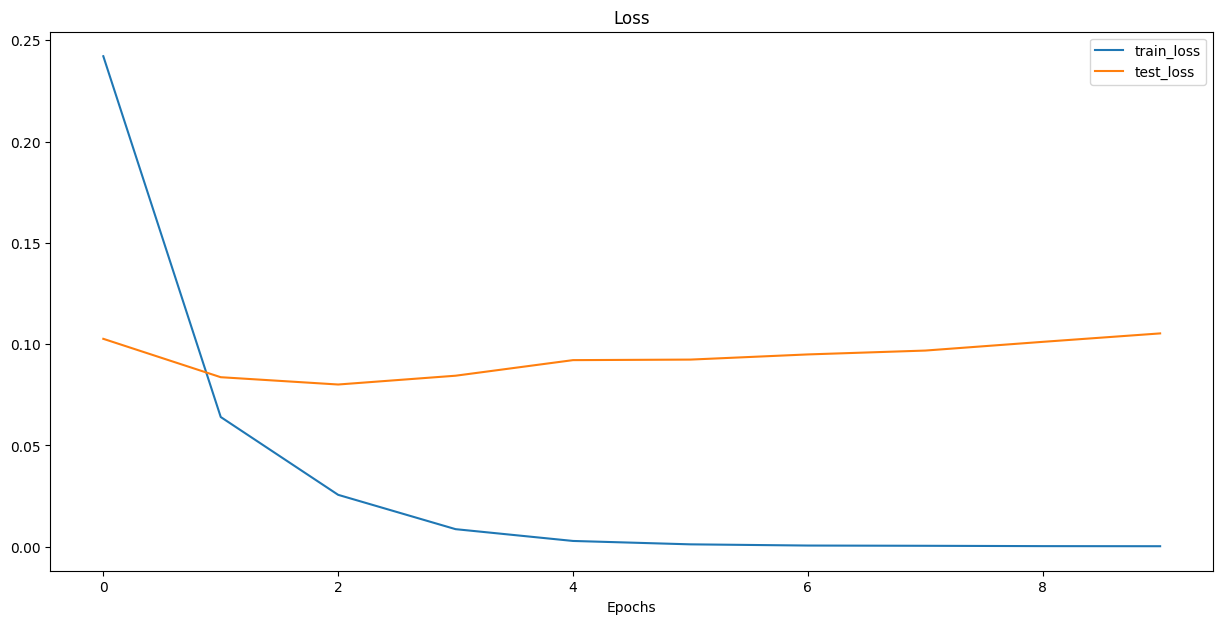

In [21]:
results = train(model=model,
          train_data_loader = train_dataloader,
          test_data_loader = valid_dataloader,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

plot_loss_curves(results)